# Классификация даты документа

## Предварительная работа

### Библиотеки

In [15]:
!pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis


In [1]:
import artm
import fasttext
import fasttext.util
import json
import io
import itertools
import nltk
import re
import requests
import torch
import pymorphy2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost                import CatBoostClassifier
from collections             import defaultdict
from copy                    import deepcopy
from matplotlib.image        import imread
from mpl_toolkits            import mplot3d
from matplotlib              import gridspec
from nerus                   import load_nerus
from nltk.tokenize           import RegexpTokenizer
from skimage.segmentation    import mark_boundaries
from sklearn.metrics         import classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.utils           import shuffle
from torch.utils             import data
from torch.utils.tensorboard import SummaryWriter
from torchvision             import datasets, transforms
from tqdm.autonotebook       import tqdm
from razdel                  import tokenize
from PIL                     import Image
from urllib.request          import urlopen


/tmp/ipykernel_4476/827032498.py:32: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook       import tqdm


### Предобработка данных

#### Токенизаторы

In [17]:
nltk.download('punkt')

word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language="russian")


[nltk_data] Downloading package punkt to /home/panterrich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Лематизатор для русского


In [18]:
nltk.download('stopwords')
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = nltk.corpus.stopwords.words('russian')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/panterrich/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/home/panterrich/.local/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [19]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]


Будем использовать готовый cvs, полученную после предпроцессинга описанного выше

In [3]:
# data_text = data['text']
# for i in tqdm(range(len(data))):
#     data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
# data.to_csv('drive/MyDrive/DATASETS/MachineLearning'
#             '/topicmodeling/lenta-ru-proccess.csv', index=False)

data = pd.read_csv('lenta-ru-proccess.csv')


In [21]:
data


,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [2]:
filename_valid = 'vw_data/texts_valid.vw.txt'
filename_train = 'vw_data/texts_train.vw.txt'


In [7]:
counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = '_'.join(data.loc[i]['date'].split('-')[2:])

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@year class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append(str(label).lower().strip())
                else:
                    fout_train.write('doc_{} {} |@year class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append(str(label).lower().strip())


  0%|          | 0/863285 [00:00<?, ?it/s]

In [8]:
with open('vw_data/y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('vw_data/y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))


In [25]:
!head -2 vw_data/texts_train.vw.txt
!head -2 vw_data/texts_valid.vw.txt

!wc -l vw_data/texts_train.vw.txt
!wc -l vw_data/texts_valid.vw.txt


doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

### Создаём батчи

In [3]:
bv_train = artm.BatchVectorizer(
    data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='vw_batches/batches_train')

bv_test = artm.BatchVectorizer(
    data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='vw_batches/batches_valid')


### Создаём словарь

In [4]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='vw_batches/batches_train')


## Создаем модели и обучаем

Рассмотрим четыре модели ARTM: стандартную, с дополнительной модальностью (метка года), и те же самые, но с добавленными регулязаторами.

In [7]:
# default
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary)

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi'))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_phi': model.score_tracker['sparsity_phi'].value[-1]})

model.dump_artm_model('model/default')


  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# add modality
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary,
                  class_ids= {'@default_class': 1.0, '@year': 50.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi', class_id='@year'))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_phi': model.score_tracker['sparsity_phi'].value[-1]})

model.dump_artm_model('model/modality')


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
# add regularizers
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary)

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi'))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_def', tau=-1.0))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_def', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def', tau=1e5))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_phi': model.score_tracker['sparsity_phi'].value[-1]})

model.dump_artm_model('model/regularizers')


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# add modality and regularizers
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary,
                  class_ids = {'@default_class': 1.0, '@year': 50.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi', class_id='@year'))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_def', tau=-1.0))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_def', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(
        name='decorrelator_phi_def', class_ids=['@default_class'], tau=1e2))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(
        name='decorrelator_phi_lab', class_ids=['@year'], tau=1e5))


iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity_phi': model.score_tracker['sparsity_phi'].value[-1]})

model.dump_artm_model('model/modality_regularizers')


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
def DefaultModel():
    model = artm.load_artm_model('model/default/')

    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi'), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

    return model

def ReqularizersModel():
    model = artm.load_artm_model('model/regularizers/')

    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi'), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

    return model

def ModalityModel():
    model = artm.load_artm_model('model/modality/')

    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi', class_id='@year'), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

    return model

def ModalityReqularizersModel():
    model = artm.load_artm_model('model/modality_regularizers/')

    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi', class_id='@year'), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

    return model


## Анализ метрик моделей

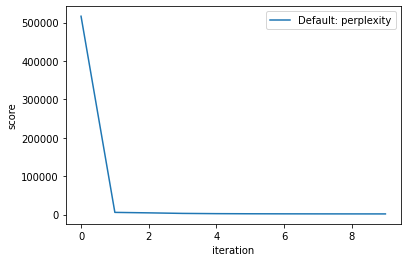

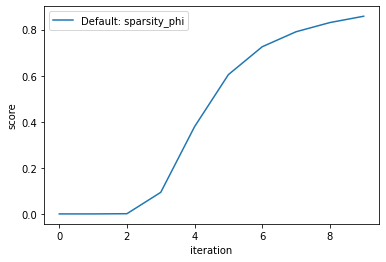

1550.5347900390625
0.8581143617630005
['чечня', 'кадыров', 'чеченский', 'республика', 'муж', 'это', 'грозный', 'брак', 'рамзан', 'глава']
['клуб', 'сезон', 'игрок', 'лига', 'играть', 'чемпионат', 'выступать', 'состав', 'это', 'который']
['чёрный', 'c', 'технический', 'копия', 'год', 'процессор', 'использоваться', 'конструкция', 'который', 'l']
['программа', 'развитие', 'план', 'поддержка', 'сокращение', 'рамка', 'планироваться', 'сократить', 'оборудование', 'реализовать']
['стадион', 'сочи', 'аэс', 'казань', '2018', 'атомный', 'реактор', 'март', 'арен', 'волгоград']


In [7]:
model = DefaultModel()

plt.plot(model.score_tracker['perplexity'].value, label = 'Default: perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

plt.plot(model.score_tracker['sparsity_phi'].value, label = 'Default: sparsity_phi')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

top_tokens = model.score_tracker['top-tokens'].last_tokens

print(model.score_tracker['perplexity'].value[-1])
print(model.score_tracker['sparsity_phi'].value[-1])

for topic_name in model.topic_names[-5:]:
    print(top_tokens[topic_name])


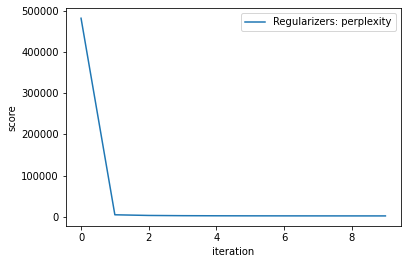

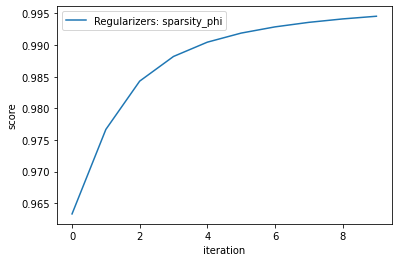

1692.2239990234375
0.9945456981658936
['чечня', 'республика', 'чеченский', 'кадыров', 'грозный', 'глава', 'рамзан', 'попов', 'чеченец', 'кс']
['сезон', 'клуб', 'игрок', 'год', 'нхл', 'хоккейный', 'лига', 'хоккеист', 'выступать', 'состав']
['c', 'процессор', 'ноутбук', 'intel', 'память', 'козлов', 'компьютер', 'чип', 'гигабайт', 'r']
['проект', 'поддержка', 'программа', 'развитие', 'топливо', 'реализация', 'план', 'электроэнергия', 'планироваться', '2024']
['япония', 'японский', 'аэс', 'стадион', 'мексика', 'нижний', 'новгород', 'казань', 'атомный', 'реактор']


In [8]:
model = ReqularizersModel()

plt.plot(model.score_tracker['perplexity'].value, label = 'Regularizers: perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

plt.plot(model.score_tracker['sparsity_phi'].value, label = 'Regularizers: sparsity_phi')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

print(model.score_tracker['perplexity'].value[-1])
print(model.score_tracker['sparsity_phi'].value[-1])

top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names[-5:]:
    print(top_tokens[topic_name])


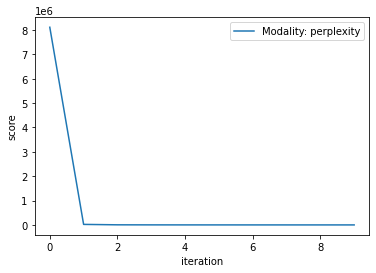

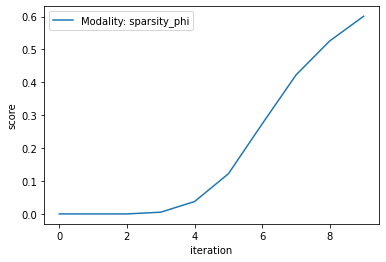

3354.4658203125
0.6008695363998413
['республика', 'глава', 'чечня', 'президент', 'кадыров', 'чеченский', 'казахстан', 'пост', 'должность', 'это']
['клуб', 'япония', 'футбольный', 'тренер', 'японский', 'лига', 'футболист', 'чемпионат', 'россия', 'игрок']
['который', '2006', 'год', 'система', 'также', 'время', 'мочь', 'весь', 'новый', 'проект']
['нефть', 'цена', 'тонна', 'экспорт', 'поставка', 'топливо', 'баррель', 'страна', 'добыча', 'пошлина']
['газа', 'газпром', 'украина', 'российский', 'газ', 'кубометр', 'россия', 'газовый', 'поставка', 'украинский']


In [10]:
model = ModalityModel()

plt.plot(model.score_tracker['perplexity'].value, label = 'Modality: perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

plt.plot(model.score_tracker['sparsity_phi'].value, label = 'Modality: sparsity_phi')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

print(model.score_tracker['perplexity'].value[-1])
print(model.score_tracker['sparsity_phi'].value[-1])

top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names[-5:]:
    print(top_tokens[topic_name])


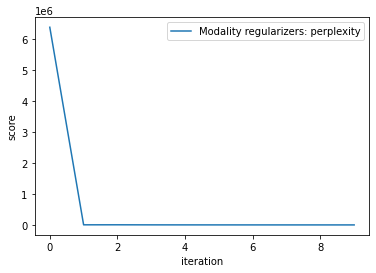

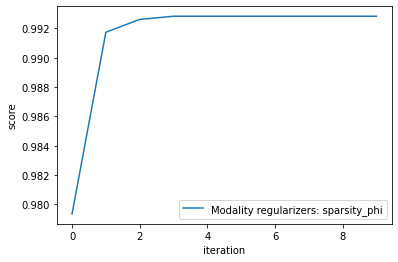

6684.2333984375
0.9928261041641235
['пост', 'мэр', 'должность', 'глава', 'президент', 'отставка', 'решение', 'совет', 'обязанность', 'занимать']
['путин', 'россия', 'президент', 'владимир', 'медведев', 'глава', 'российский', 'государство', 'вопрос', 'премьер']
['устройство', 'экран', 'компьютер', 'камера', 'процессор', 'память', 'модель', 'планшет', 'ноутбук', 'компания']
['цена', 'продукция', 'рынок', 'производитель', 'топливо', 'товар', 'фас', 'тариф', 'тонна', 'производство']
['турнир', 'финал', 'россиянка', 'матч', 'уильямс', 'круг', '4', 'мария', 'шарапов', '1']


In [9]:
model = ModalityReqularizersModel()

plt.plot(model.score_tracker['perplexity'].value, label = 'Modality regularizers: perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

plt.plot(model.score_tracker['sparsity_phi'].value, label = 'Modality regularizers: sparsity_phi')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

print(model.score_tracker['perplexity'].value[-1])
print(model.score_tracker['sparsity_phi'].value[-1])

top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names[-5:]:
    print(top_tokens[topic_name])


## Классификация

Для классификации будем использовать CatBoostClassifier

In [6]:
model = DefaultModel()

with open('vw_data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

X_train_pd = model.transform(bv_train)

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)

classifier = CatBoostClassifier(iterations=10,
                                learning_rate=1,
                                depth=2,
                                loss_function='MultiClass')

classifier.fit(X_train, y_train)


  0%|          | 0/653795 [00:00<?, ?it/s]

0:	learn: 3.0130310	total: 1.34s	remaining: 12.1s
1:	learn: 4.2589532	total: 2.59s	remaining: 10.4s
2:	learn: 45.6621658	total: 3.95s	remaining: 9.21s
3:	learn: 21.7789641	total: 5.21s	remaining: 7.81s
4:	learn: 34.8528614	total: 6.76s	remaining: 6.76s
5:	learn: 43.9440570	total: 7.92s	remaining: 5.28s
6:	learn: 21.9985863	total: 9.22s	remaining: 3.95s
7:	learn: 34.9161489	total: 10.5s	remaining: 2.63s
8:	learn: 24.5854206	total: 12.1s	remaining: 1.34s
9:	learn: 34.6236105	total: 13.4s	remaining: 0us


In [7]:
with open('vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

X_valid_pd = model.transform(bv_test)

X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

pred = classifier.predict(X_valid)

with open('report/Default.txt', 'w') as f:
    f.write(str(classification_report(y_valid, pred, zero_division=1)))


  0%|          | 0/6604 [00:00<?, ?it/s]

In [7]:
model = ReqularizersModel()

with open('vw_data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

X_train_pd = model.transform(bv_train)

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)

classifier = CatBoostClassifier(iterations=10,
                                learning_rate=1,
                                depth=2,
                                loss_function='MultiClass')

classifier.fit(X_train, y_train)


  0%|          | 0/653795 [00:00<?, ?it/s]

0:	learn: 3.0450222	total: 1.41s	remaining: 12.7s
1:	learn: 46.6360616	total: 2.88s	remaining: 11.5s
2:	learn: 48.2772193	total: 4.38s	remaining: 10.2s
3:	learn: 30.4737064	total: 5.98s	remaining: 8.97s
4:	learn: 65.3233083	total: 7.44s	remaining: 7.44s
5:	learn: 44.0271029	total: 8.88s	remaining: 5.92s
6:	learn: 33.2280402	total: 10.5s	remaining: 4.49s
7:	learn: 63.6374050	total: 12s	remaining: 2.99s
8:	learn: 44.6168177	total: 13.4s	remaining: 1.49s
9:	learn: 46.1946937	total: 15s	remaining: 0us


In [8]:
with open('vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

X_valid_pd = model.transform(bv_test)

X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

pred = classifier.predict(X_valid)

with open('report/Reqularizers.txt', 'w') as f:
    f.write(str(classification_report(y_valid, pred, zero_division=1)))


  0%|          | 0/6604 [00:00<?, ?it/s]

In [8]:
model = ModalityModel()

with open('vw_data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

X_train_pd = model.transform(bv_train)

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)

classifier = CatBoostClassifier(iterations=10,
                                learning_rate=1,
                                depth=2,
                                loss_function='MultiClass')

classifier.fit(X_train, y_train)


  0%|          | 0/653795 [00:00<?, ?it/s]

0:	learn: 2.7362652	total: 1.52s	remaining: 13.7s
1:	learn: 2.3930199	total: 2.81s	remaining: 11.3s
2:	learn: 2.0328799	total: 4.23s	remaining: 9.86s
3:	learn: 1.7041708	total: 5.67s	remaining: 8.51s
4:	learn: 1.5111043	total: 6.92s	remaining: 6.92s
5:	learn: 1.2621076	total: 8.22s	remaining: 5.48s
6:	learn: 0.9787315	total: 9.55s	remaining: 4.09s
7:	learn: 0.7609050	total: 10.8s	remaining: 2.69s
8:	learn: 0.6202573	total: 12.2s	remaining: 1.36s
9:	learn: 0.5147612	total: 13.4s	remaining: 0us


In [9]:
with open('vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

X_valid_pd = model.transform(bv_test)

X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

pred = classifier.predict(X_valid)

with open('report/Modality.txt', 'w') as f:
    f.write(str(classification_report(y_valid, pred, zero_division=1)))


  0%|          | 0/6604 [00:00<?, ?it/s]

In [10]:
model = ModalityReqularizersModel()

with open('vw_data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

X_train_pd = model.transform(bv_train)

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)

classifier = CatBoostClassifier(iterations=10,
                                learning_rate=1,
                                depth=2,
                                loss_function='MultiClass')

classifier.fit(X_train, y_train)


  0%|          | 0/653795 [00:00<?, ?it/s]

0:	learn: 2.5077182	total: 1.11s	remaining: 9.96s
1:	learn: 2.2318394	total: 2.05s	remaining: 8.21s
2:	learn: 1.8884469	total: 2.98s	remaining: 6.94s
3:	learn: 1.6508448	total: 3.95s	remaining: 5.92s
4:	learn: 1.3698338	total: 4.86s	remaining: 4.86s
5:	learn: 3.7209257	total: 5.85s	remaining: 3.9s
6:	learn: 4.4792997	total: 7.3s	remaining: 3.13s
7:	learn: 33.1865622	total: 8.87s	remaining: 2.22s
8:	learn: 32.9856782	total: 10.3s	remaining: 1.15s
9:	learn: 31.0293515	total: 11.9s	remaining: 0us


In [11]:
with open('vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

X_valid_pd = model.transform(bv_test)

X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

pred = classifier.predict(X_valid)

with open('report/ModalityRegularizers.txt', 'w') as f:
    f.write(str(classification_report(y_valid, pred, zero_division=1)))


  0%|          | 0/6604 [00:00<?, ?it/s]

## Результаты

Для задачи классификации даты документа использовался тематический вектор в качестве векторного представления текста, а в качестве модели классификатора использовался CatBoostClassifier. Добавление дополнительной модальности (год документа) в модели ARTM существенно позволил увеличить качество. Регулялизаторы несколько понизили качество классификации, но при этом увеличили сходимость модели ARTM.

Наилучшее средневзвешенное значение F1-меры составило 0.87 для 22 классов. При этом значение sparsity-phi составило всего 0.6, что меньше, чем у остальных моделей, а значение perplexity - 3354, что в два раза больше, чем при отсутствии дополнительной модальности. 